In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(sys.path[0])))))
print(os.getcwd())
print(sys.path[0])


%matplotlib inline
%load_ext autoreload
%autoreload 2

/accounts/grad/wtorous/rule-vetting
/accounts/grad/wtorous/rule-vetting/rulevetting/projects/csi_pecarn/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#from sklearn.preprocessing import StandardScaler
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [3]:
eda_df = Dataset().get_data()

kwargs {'clean_data': {'use_kappa': False, 'use_robust_av': True}, 'preprocess_data': {'frac_missing_allowed': 0.05}, 'extract_features': {'drop_negative_columns': False}}


In [4]:
outcome_def = 'csi_injury'

In [5]:
# get columns with a single unique value
# TODO: automate in loading process
no_information_columns = eda_df.columns[eda_df.nunique() <= 1]
eda_df.drop(no_information_columns, axis=1, inplace=True)

print(eda_df.shape)

(3314, 173)


In [6]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df[binary_columns]

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df[cont_columns]
cont_eda_data[outcome_def] = eda_df[outcome_def]

<ipython-input-6-bf1c91b1b7d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_eda_data[outcome_def] = eda_df[outcome_def]


In [7]:
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(3314, 173)
(3314, 160)
(3314, 14)


# Summary EDA

In [8]:
eda_df.describe()

,AgeInYears,AlteredMentalStatus2,ArrivalTimeND,Assault,AxialLoadAnyDoc,BodyAsAWhole0,BodyAsAWhole2,BodyAsAWhole3,BodyAsAWhole5,BodyAsAWhole6,...,PtCompPain_binary,PtCompPainNeckMove_binary,PtExtremityWeakness_binary,PtParesthesias_binary,PtSensoryLoss_binary,PtTender_binary,ReceivedInTransfer_binary,Respiratory_binary,clotheslining_binary,helmet_binary
count,3314.000000,3245.000000,3314.000000,208.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,...,2483.000000,220.000000,2532.000000,2152.000000,2302.000000,2455.000000,3314.000000,2602.000000,1115.000000,715.000000
mean,9.974252,0.252388,0.025649,0.509615,0.239891,0.003923,0.000302,0.000302,0.000302,0.022028,...,0.858639,0.722727,0.067536,0.088290,0.069939,0.530754,0.220881,0.202537,0.027803,0.353846
std,4.714381,0.434450,0.158109,0.501114,0.427081,0.062518,0.017371,0.017371,0.017371,0.146796,...,0.348464,0.448673,0.250997,0.283782,0.255100,0.499155,0.414903,0.401967,0.164481,0.478497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.702500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.090000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,14.220000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
binary_corrs = binary_eda_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')
#corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
#corrmap.ax_row_dendrogram.set_visible(False)
#corrmap.ax_col_dendrogram.set_visible(False)

In [10]:
print(binary_corrs)

                           AlteredMentalStatus2  ArrivalTimeND   Assault  \
AlteredMentalStatus2                   1.000000       0.013221  0.123783   
ArrivalTimeND                          0.013221       1.000000  0.096656   
Assault                                0.123783       0.096656  1.000000   
AxialLoadAnyDoc                       -0.046259      -0.001747 -0.283706   
BodyAsAWhole0                         -0.036850      -0.010182 -0.070855   
...                                         ...            ...       ...   
PtTender_binary                       -0.174274       0.032534  0.152197   
ReceivedInTransfer_binary              0.118288       0.028643 -0.092938   
Respiratory_binary                    -0.013593      -0.032051 -0.085849   
clotheslining_binary                  -0.059561      -0.028120 -0.033694   
helmet_binary                         -0.094678       0.011777       NaN   

                           AxialLoadAnyDoc  BodyAsAWhole0  BodyAsAWhole2  \
AlteredMent

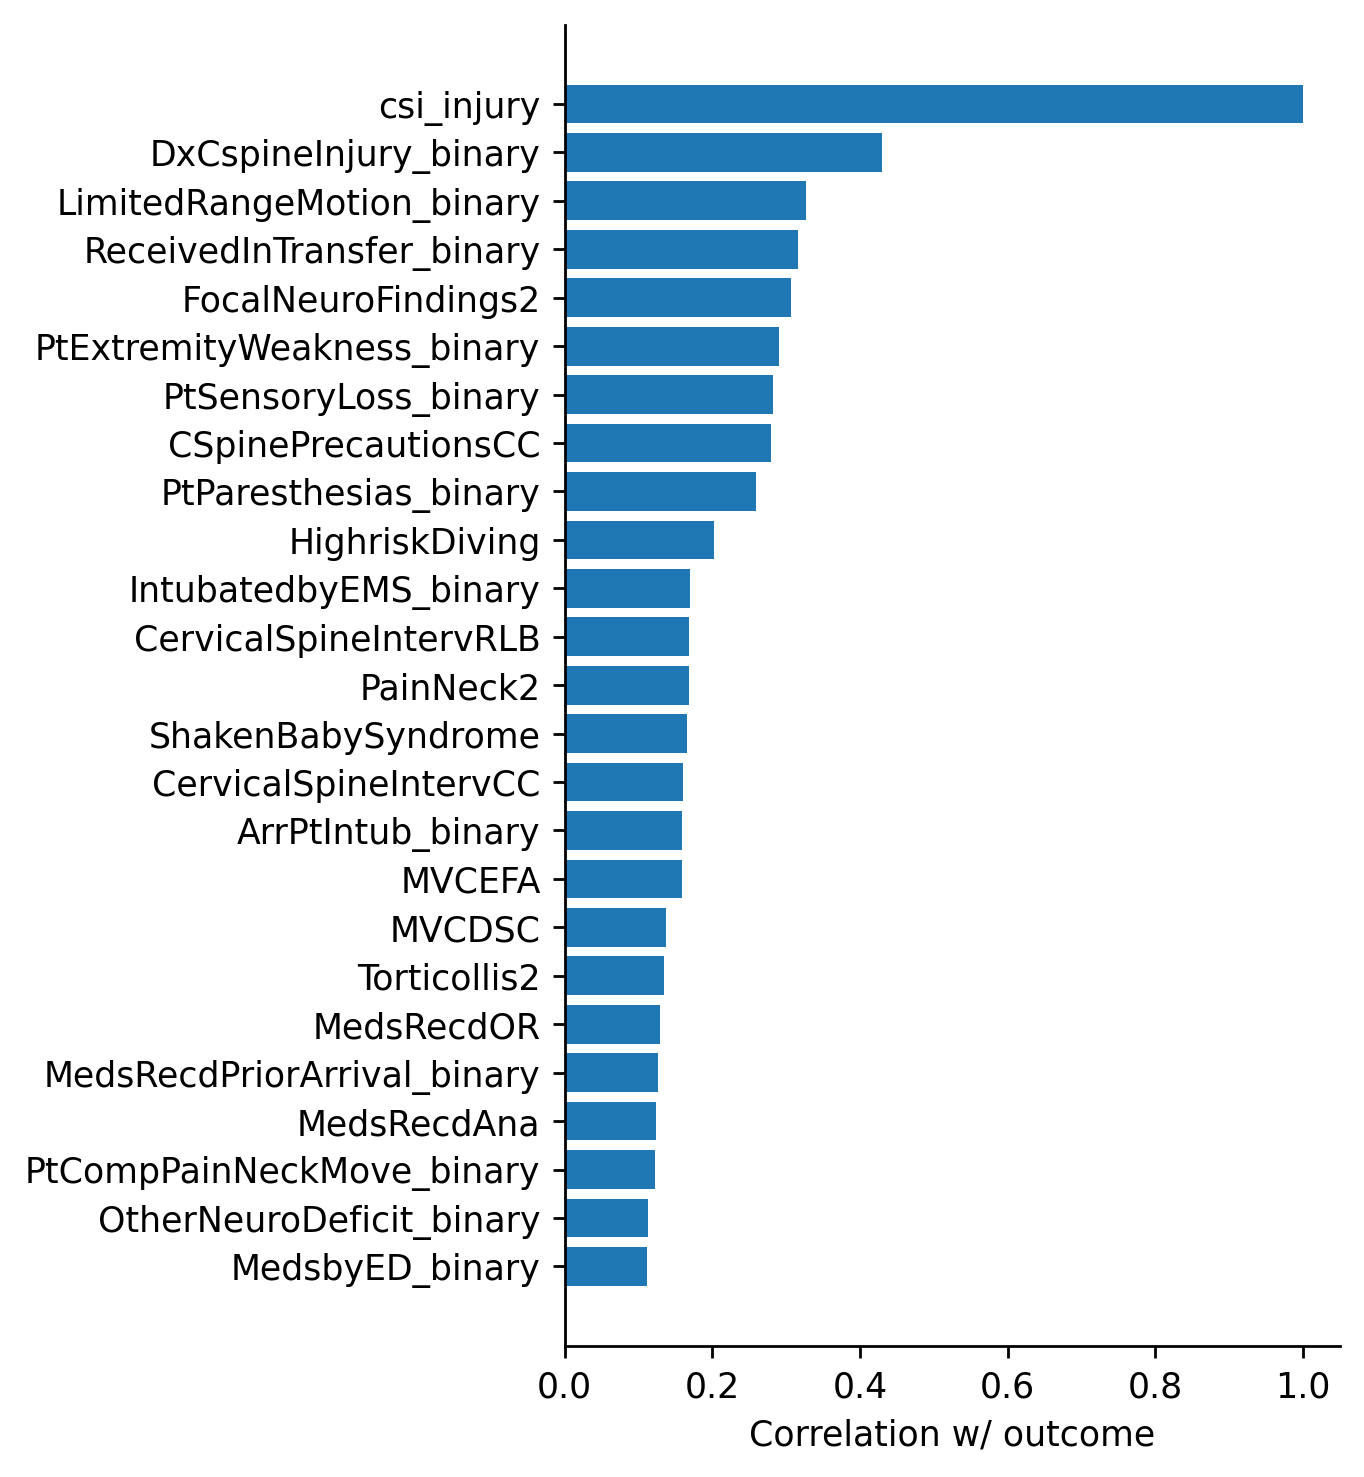

In [11]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[-25:], vals[args][-25:])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

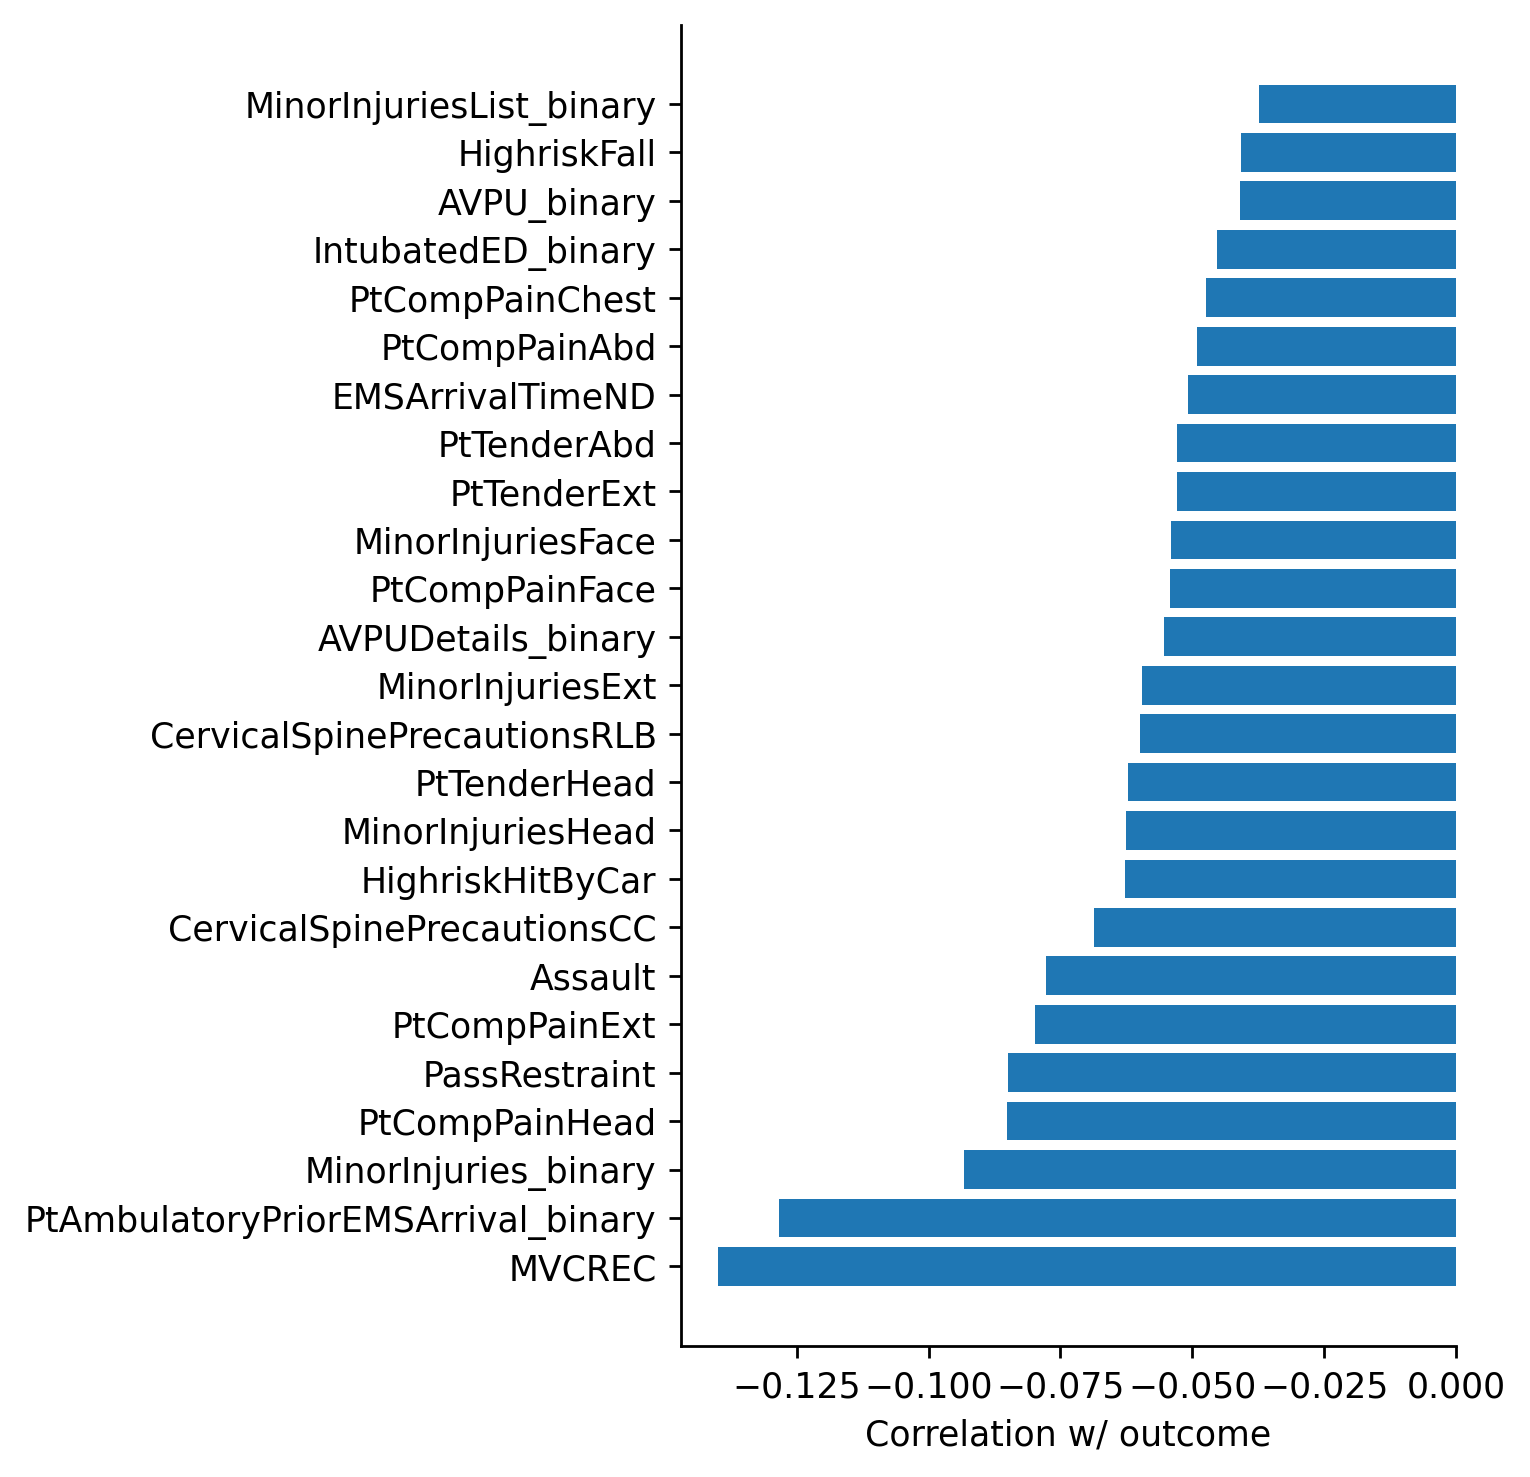

In [12]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

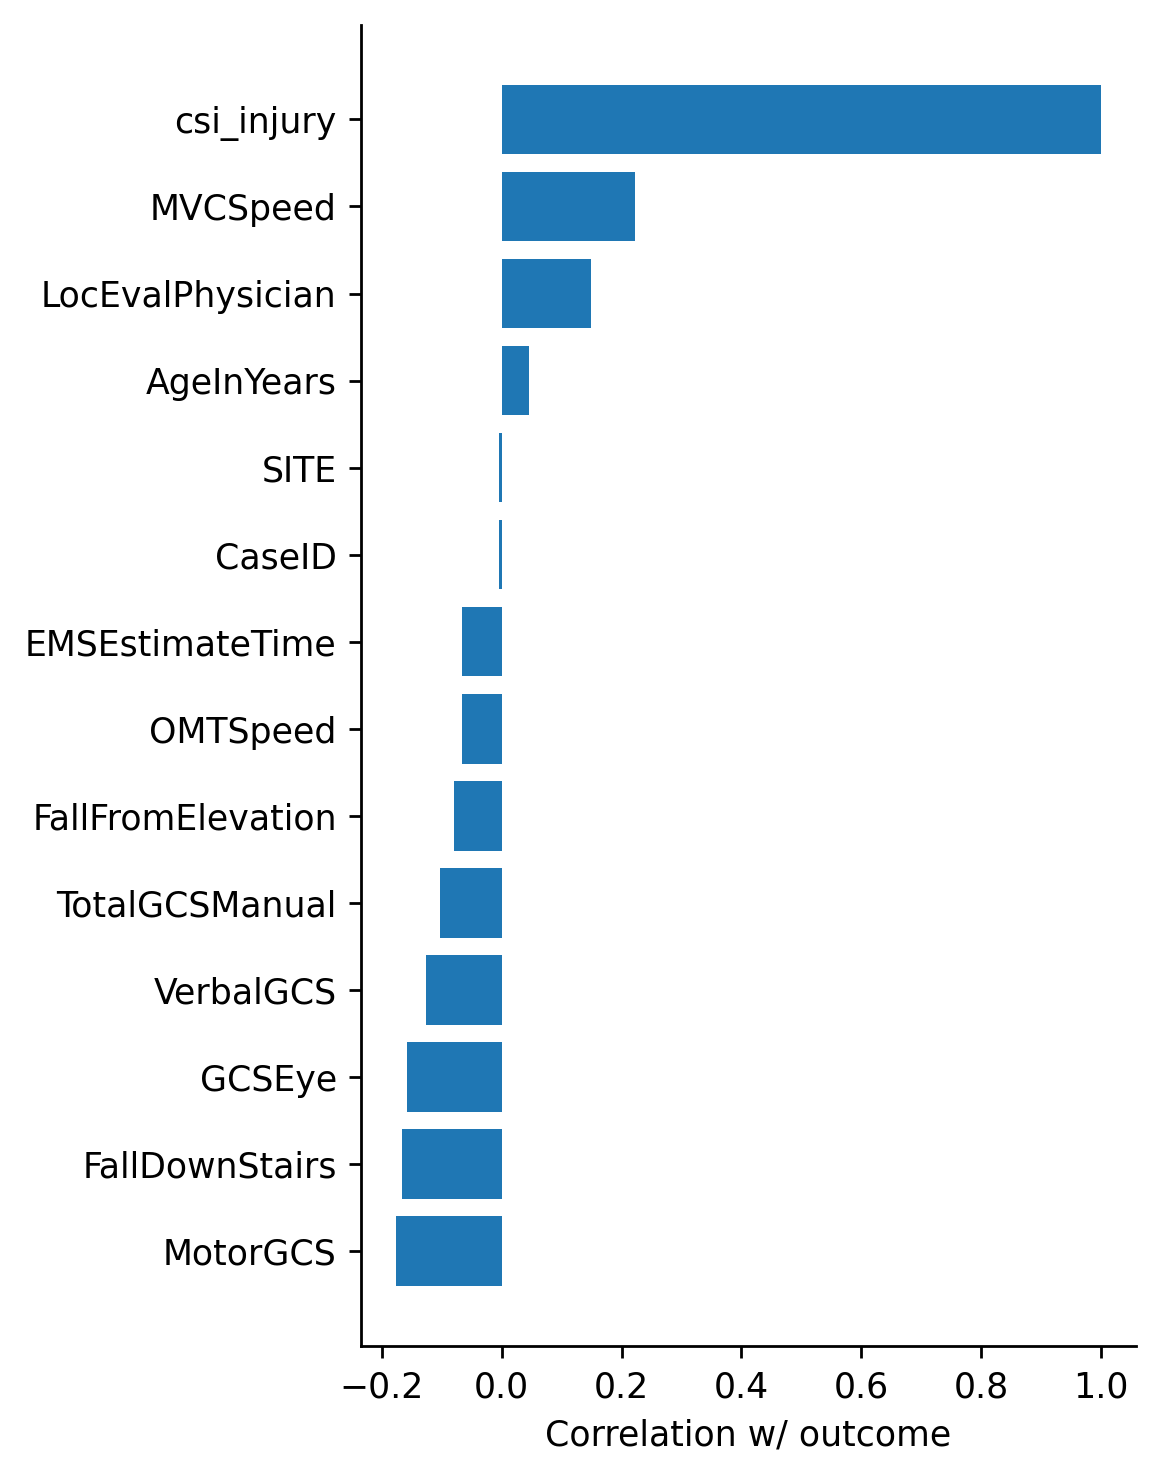

In [13]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# EDA of Missingness

In [14]:
# get percent missing by column
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:25])

print("\nContinuous Covariates:")
bin_missing_frac = (binary_eda_data.isna().sum() / binary_eda_data.shape[0]) * 100
print(bin_missing_frac.sort_values(ascending=False)[:25])

25 Covariates with Highest Percent Missingness

All Covariates:
OMTSpeed                              98.913699
FallDownStairs                        97.284249
Assault                               93.723597
ShakenBabySyndrome                    93.723597
ChildAbuse                            93.723597
PtCompPainNeckMove_binary             93.361497
EMSEstimateTime                       88.563669
MVCSpeed                              88.050694
FallFromElevation                     86.481593
IntubatedED_binary                    83.011467
MedsbyED_binary                       82.377791
helmet_binary                         78.424864
LimitedRangeMotion_binary             74.864212
PassRestraint                         74.652987
MVCHOC                                73.174412
MVCSI                                 73.174412
MVCRO                                 73.174412
MVCREC                                73.174412
MVCDSC                                73.174412
MVCEFA                  

In [15]:
complete_binary_covar = binary_columns[bin_missing_frac==0]
print("Binary covar. with no missing data:",len(complete_binary_covar))

missing_columns = binary_columns[bin_missing_frac!=0]
print("Binary covar. with some missing data:",len(missing_columns))

Binary covar. with no missing data: 100
Binary covar. with some missing data: 60


In [16]:
binary_missing_bools = binary_eda_data[missing_columns].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

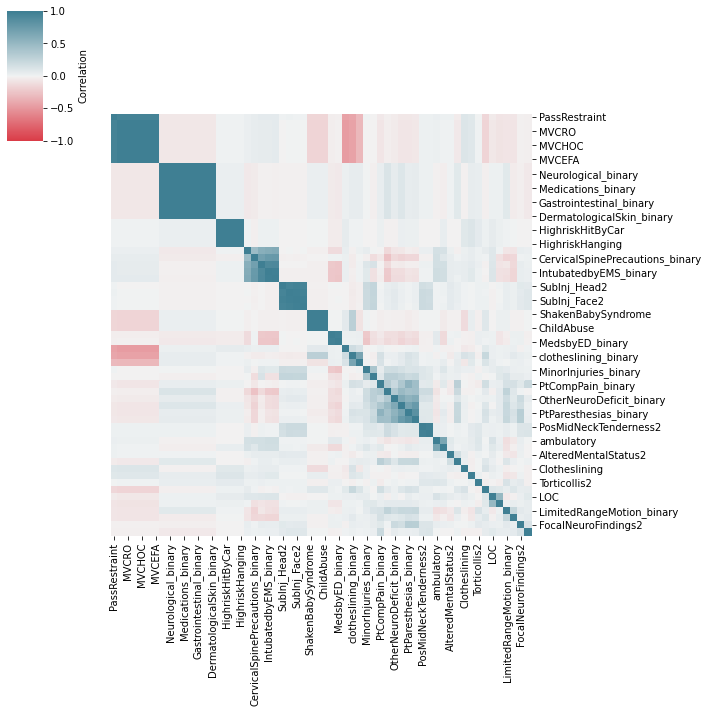

In [17]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

# EDA of Demographic Data

In [18]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

Index(['site', 'caseid', 'controltype', 'AgeInYears', 'Gender', 'Race',
       'Ethnicity', 'PayorType', 'PayorTypeCI', 'PayorTypeMA'],
      dtype='object')


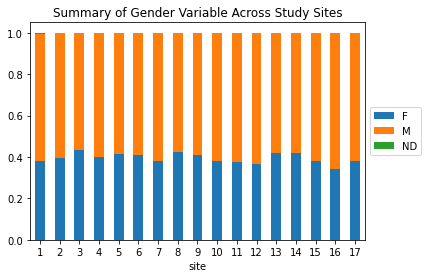

In [19]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

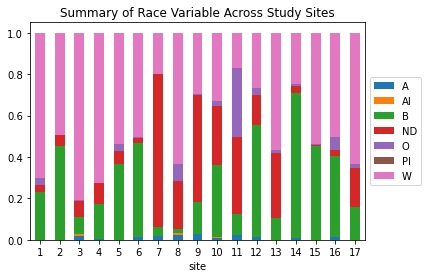

In [20]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

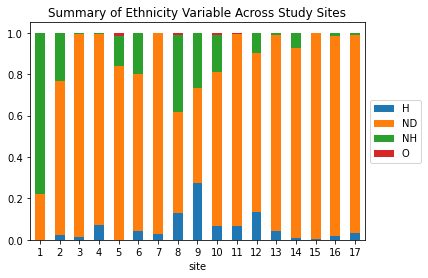

In [21]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

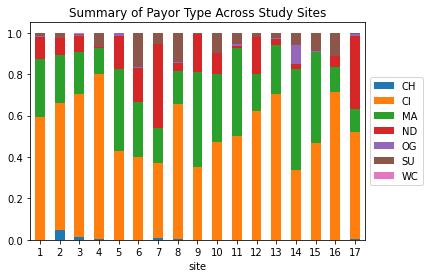

In [22]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

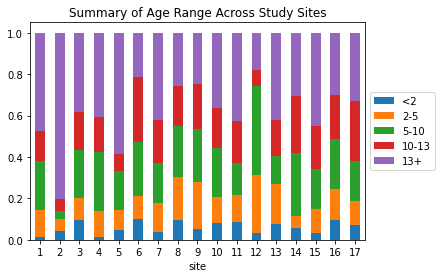

In [26]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
